In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

#path to zipfile
zip_file_path = "/content/archive (1).zip"

#extract all contents from the zipfile
with ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall("/content/aquaponics_dataset")
  print('Extraction done')

Extraction done


In [21]:
#load the dataset
file_path = "/content/aquaponics_dataset/IoTpond1.csv"
df = pd.read_csv(file_path)

In [22]:
# Check for missing values
missing_summary = df.isnull().sum()
print("Missing Values Summary:\n", missing_summary)

Missing Values Summary:
 created_at                 0
entry_id                   0
Temperature (C)            0
Turbidity(NTU)             0
Dissolved Oxygen(g/ml)     0
PH                         0
Ammonia(g/ml)             52
Nitrate(g/ml)              0
Population                 0
Fish_Length(cm)            2
Fish_Weight(g)             2
dtype: int64


In [23]:
# Parse the 'created_at' column into a datetime format
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S %Z')

#preview
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype                    
---  ------                  --------------  -----                    
 0   created_at              83126 non-null  datetime64[ns, UTC+02:00]
 1   entry_id                83126 non-null  int64                    
 2   Temperature (C)         83126 non-null  float64                  
 3   Turbidity(NTU)          83126 non-null  int64                    
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64                  
 5   PH                      83126 non-null  float64                  
 6   Ammonia(g/ml)           83074 non-null  float64                  
 7   Nitrate(g/ml)           83126 non-null  int64                    
 8   Population              83126 non-null  int64                    
 9   Fish_Length(cm)         83124 non-null  float64                  
 10  Fish_Weight(g)          83124 non-

In [24]:
# Extract the hour from the 'created_at' column
df['hour'] = df['created_at'].dt.hour
print(df[['created_at', 'hour']])

                     created_at  hour
0     2021-06-19 00:00:05+02:00     0
1     2021-06-19 00:01:02+02:00     0
2     2021-06-19 00:01:22+02:00     0
3     2021-06-19 00:01:44+02:00     0
4     2021-06-19 00:02:07+02:00     0
...                         ...   ...
83121 2021-10-13 02:48:31+02:00     2
83122 2021-10-13 03:17:36+02:00     3
83123 2021-10-13 03:46:49+02:00     3
83124 2021-10-13 04:13:23+02:00     4
83125 2021-10-13 04:14:22+02:00     4

[83126 rows x 2 columns]


In [25]:
def calculate_hourly_mean(df, column_name):
    """
    Calculate the hourly mean for a given column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The column for which the hourly mean is to be calculated.

    Returns:
    - pd.Series: A Series indexed by hour with the mean values for the column.
    """
    # Ensure 'created_at' is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])

    # Extract the hour from the timestamp
    df['hour'] = df['created_at'].dt.hour

    # Group by hour and calculate the mean for the specified column
    hourly_mean = df.groupby('hour')[column_name].mean()

    return hourly_mean

In [26]:
# Calculate the hourly mean for the "Ammonia(g/ml)" column
hourly_mean_ammonia = calculate_hourly_mean(df, 'Ammonia(g/ml)')

# Calculate the hourly mean for the "Fish_Length(cm)" column
hourly_mean_length = calculate_hourly_mean(df, 'Fish_Length(cm)')

#Calculate the hhourly mean for the "Fish_Weight(g)" column
hourly_mean_weight = calculate_hourly_mean(df, 'Fish_Weight(g)')

In [27]:
def impute_missing_by_hourly_mean(df, column_name):
    """
    Impute missing values in a column using the hourly mean.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_name (str): The column to impute.

    Returns:
    - pd.DataFrame: DataFrame with missing values in the specified column imputed.
    """
    # Ensure 'created_at' is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
        df['created_at'] = pd.to_datetime(df['created_at'])

    # Extract the hour from the timestamp
    df['hour'] = df['created_at'].dt.hour

    # Calculate the hourly mean for the specified column
    hourly_mean = df.groupby('hour')[column_name].mean()

    # Impute missing values using the hourly mean
    df[column_name] = df.apply(
        lambda row: hourly_mean[row['hour']] if pd.isnull(row[column_name]) else row[column_name],
        axis=1
    )

    # Drop the 'hour' column to keep the DataFrame clean
    df.drop(columns=['hour'], inplace=True)

    return df


In [28]:
df = impute_missing_by_hourly_mean(df, 'Ammonia(g/ml)')
df = impute_missing_by_hourly_mean(df, 'Fish_Length(cm)')
df = impute_missing_by_hourly_mean(df, 'Fish_Weight(g)')

print(df)

                     created_at  entry_id  Temperature (C)  Turbidity(NTU)  \
0     2021-06-19 00:00:05+02:00      1889          24.8750             100   
1     2021-06-19 00:01:02+02:00      1890          24.9375             100   
2     2021-06-19 00:01:22+02:00      1891          24.8750             100   
3     2021-06-19 00:01:44+02:00      1892          24.9375             100   
4     2021-06-19 00:02:07+02:00      1893          24.9375             100   
...                         ...       ...              ...             ...   
83121 2021-10-13 02:48:31+02:00    247201          26.5625             100   
83122 2021-10-13 03:17:36+02:00    247273          26.5625             100   
83123 2021-10-13 03:46:49+02:00    247336          26.5000             100   
83124 2021-10-13 04:13:23+02:00    247402          26.3750             100   
83125 2021-10-13 04:14:22+02:00    247405          26.3750             100   

       Dissolved Oxygen(g/ml)       PH  Ammonia(g/ml)  Nitrate(

In [29]:
#identify non-numeric values
non_numeric_columns = df.select_dtypes(include=['object']).columns
print("Non-Numeric Columns:", non_numeric_columns)

Non-Numeric Columns: Index([], dtype='object')


In the next part, we will use boxplot to show outliers from each attribute.

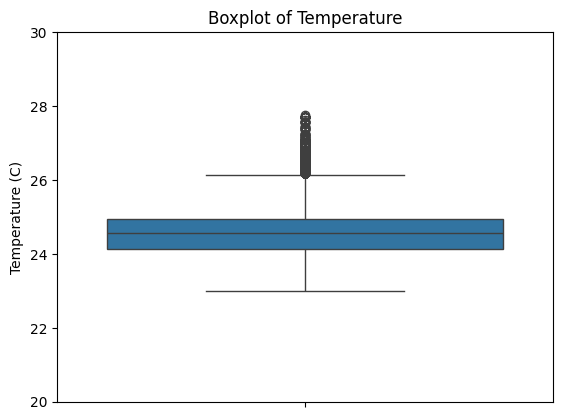

In [30]:
# boxplot for temperature
sns.boxplot(data=df, y='Temperature (C)')
plt.ylim(20,30)  # Set limits based on expected temperature range
plt.title("Boxplot of Temperature")
plt.show()


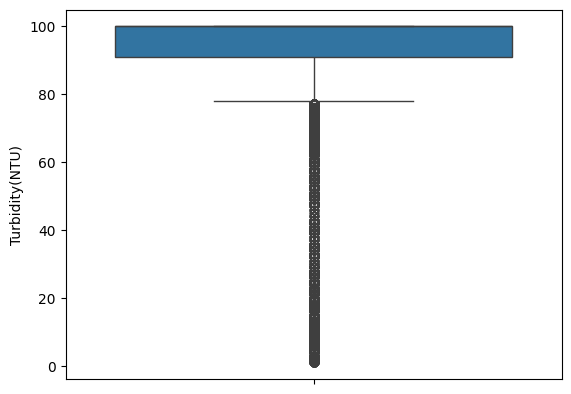

In [31]:
# boxplot for trbidity
sns.boxplot(df['Turbidity(NTU)'])
plt.show()

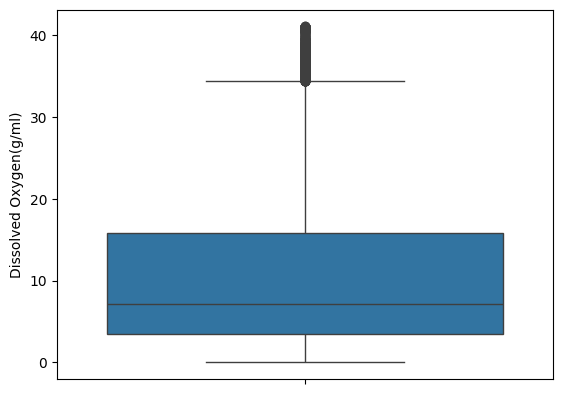

In [32]:
# boxplot for DO
sns.boxplot(df['Dissolved Oxygen(g/ml)'])
plt.show()

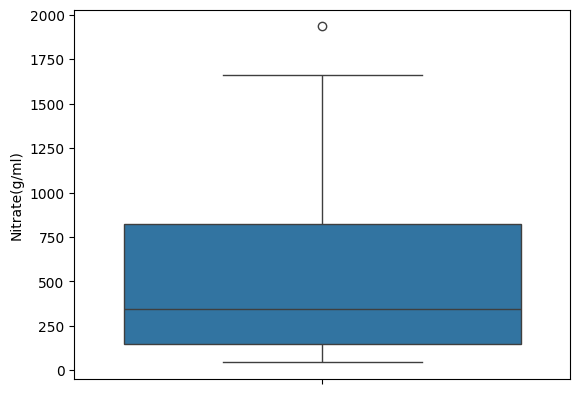

In [33]:
#boxplot for nitrate
sns.boxplot(df['Nitrate(g/ml)'])
plt.show()

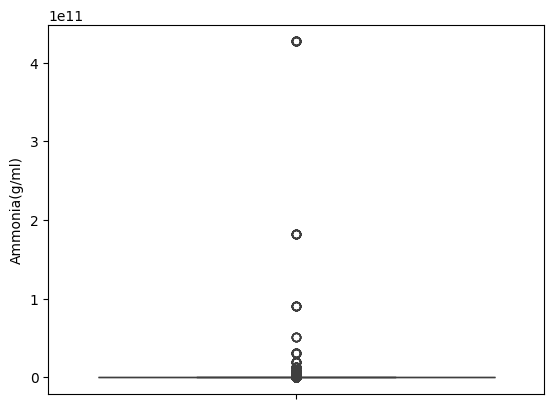

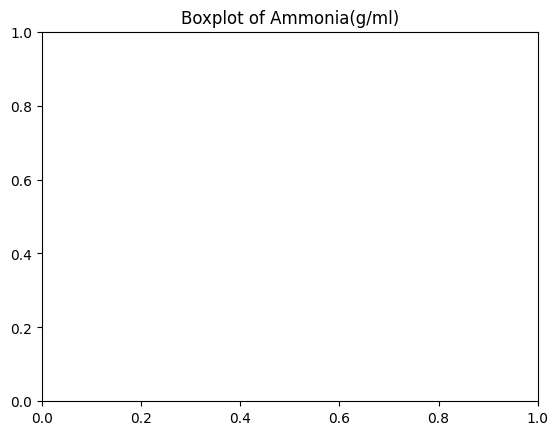

In [34]:
#boxplot for ammonia
sns.boxplot(data=df, y='Ammonia(g/ml)')
plt.show()
plt.ylim(0,1)  # Set limits based on expected temperature range
plt.title("Boxplot of Ammonia(g/ml)")
plt.show()

Now, we will begin deriving the hhourly interval from the timestamp to compute the change in weight per hour.

In [35]:
# Sort by 'created_at' to ensure proper chronological order
df = df.sort_values(by='created_at')

# Resample to hourly data and calculate the mean for each hour
df_hourly = df.resample('H').mean()

# Reset the index back to a column if needed
df_hourly.reset_index(inplace=True)

df_hourly.info()

<ipython-input-35-90a49b5c439c>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
# Calculate the difference in weight between consecutive hours
df_hourly['growth_rate'] = df_hourly['Fish_Weight(g)'].diff()  # Weight difference

# Replace near-zero values with 0
df_hourly['growth_rate'] = df_hourly['growth_rate'].apply(
    lambda x: 0 if abs(x) < 1e-10 else x
)

# Fill NaN values in growth rate with 0 or forward-fill from the previous value
df_hourly['growth_rate'].fillna(0, inplace=True)

df_hourly.head(50)

In this part, we will assess and understand if the outliers per attribute significantly affects the growthrate. This will help us deciide whether to remove or leave outliers as is.

In [ ]:

# Scatterplot of ammonia vs. fish growth rate
plt.scatter(df_hourly['Ammonia(g/ml)'], df_hourly['growth_rate'])
plt.title("Ammonia vs Growth Rate")
plt.xlabel("Ammonia (g/ml)")
plt.ylabel("Growth Rate")
plt.show()


In [ ]:
# Scatterplot of temperature vs. fish growth rate
plt.scatter(df_hourly['Temperature (C)'], df_hourly['growth_rate'])
plt.title("Temperature(C) vs Growth Rate")
plt.xlabel("Temperature(C)")
plt.ylabel("Growth Rate")
plt.show()

In [ ]:
# Scatterplot of turbidity vs. fish growth rate
plt.scatter(df_hourly['Turbidity(NTU)'], df_hourly['growth_rate'])
plt.title("Turbidity(NTU) vs Growth Rate")
plt.xlabel("Turbidity(NTU)")
plt.ylabel("Growth Rate")
plt.show()

In [ ]:
# Scatterplot of Dissolved Oxygen(g/ml) vs. fish growth rate
plt.scatter(df_hourly['Dissolved Oxygen(g/ml)'], df_hourly['growth_rate'])
plt.title("Dissolved Oxygen(g/ml) vs Growth Rate")
plt.xlabel("Dissolved Oxygen(g/ml)")
plt.ylabel("Growth Rate")
plt.show()

In [ ]:
# Scatterplot of PH vs. fish growth rate
plt.scatter(df_hourly['PH'], df_hourly['growth_rate'])
plt.title("PH vs Growth Rate")
plt.xlabel("PH")
plt.ylabel("Growth Rate")
plt.show()

In [ ]:
# Scatterplot of nitrate vs. fish growth rate
plt.scatter(df_hourly['Nitrate(g/ml)'], df_hourly['growth_rate'])
plt.title("Nitrate(g/ml) vs Growth Rate")
plt.xlabel("Nitrate(g/ml)")
plt.ylabel("Growth Rate")
plt.show()

Now, we will try to remove the outliers using IQR

In [ ]:
#removing outliers using IQR

# Calculate IQR for temperature
Q1 = df_hourly['Ammonia(g/ml)'].quantile(0.25)
Q3 = df_hourly['Ammonia(g/ml)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers temporarily
filtered_df = df_hourly[(df_hourly['Ammonia(g/ml)'] >= lower_bound) & (df_hourly['Ammonia(g/ml)'] <= upper_bound)]

# Plot the boxplot without outliers
sns.boxplot(data=filtered_df, y='Ammonia(g/ml)')
plt.title("Boxplot of Ammonia(g/ml) Without Outliers")
plt.show()


In [ ]:
# Scatterplot of nitrate vs. fish growth rate
plt.scatter(filtered_df['Ammonia(g/ml)'], filtered_df['growth_rate'])
plt.title("Ammonia(g/ml) vs Growth Rate")
plt.xlabel("Ammonia(g/ml)")
plt.ylabel("Growth Rate")
plt.show()

In [ ]:
# Apply log transformation
filtered_df['log_ammonia'] = np.log(filtered_df['Ammonia(g/ml)'])

# Plot the transformed boxplot
sns.boxplot(data=filtered_df, y='log_ammonia')
plt.title("Boxplot of Log-Transformed Ammonia")
plt.show()